# Monthly Payment Features

In [1]:
import numpy as np
import pandas as pd
import gc

pd.set_option('display.float_format', '{:.10f}'.format)
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
from data_io import features_downcast
from imp import reload
import downcast
reload(downcast)
from downcast import save_dataframe32, save_dataframe32_int, load_dataframe32

In [2]:
train = pd.read_csv('./data/train.csv')
historical_transactions = pd.read_csv('./data/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('./data/new_merchant_transactions.csv')

In [3]:
all_transactions = pd.concat([historical_transactions, new_merchant_transactions], axis=0)

In [4]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.7033309100,2017-06-25 15:33:07,1.0000000000,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.7331284800,2017-07-15 12:10:45,1.0000000000,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.7203860000,2017-08-09 22:04:29,1.0000000000,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.7353524100,2017-09-02 10:06:26,1.0000000000,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.7228653800,2017-03-10 01:14:19,1.0000000000,16,37


In [5]:
def shift_round(col):
    # shift_round: reverse normalization ?
    # where are the two numbers come from ?
    return np.round(col / 0.00150265118 + 497.06, 2)

all_transactions["purchase_amount_new"] = shift_round(all_transactions["purchase_amount"])

In [6]:
all_transactions.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
purchase_amount_new     float64
dtype: object

In [7]:
all_transactions["month_abs"] = all_transactions.purchase_date.apply(lambda x: int(x[:7].replace("-", "")))

In [8]:
month_map = sorted(all_transactions.month_abs.unique())
month_map = dict(zip(month_map, range(len(month_map))))

In [9]:
all_transactions["month_lag"] = all_transactions.month_abs.map(month_map)

In [10]:
all_transactions.month_lag.value_counts().sort_index()

0     1147922
1     1206048
2     1456591
3     1448973
4     1562029
5     1698931
6     2045658
7     2233312
8     2432105
9     2547286
10    2872400
11    3480297
12    2937362
13    2541919
14     806902
15     657657
Name: month_lag, dtype: int64

In [11]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_amount_new,month_abs
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,5,-0.7033309100,2017-06-25 15:33:07,1.0000000000,16,37,29.0000000000,201706
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,6,-0.7331284800,2017-07-15 12:10:45,1.0000000000,16,16,9.1700000000,201707
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,7,-0.7203860000,2017-08-09 22:04:29,1.0000000000,16,37,17.6500000000,201708
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,8,-0.7353524100,2017-09-02 10:06:26,1.0000000000,16,34,7.6900000000,201709
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,2,-0.7228653800,2017-03-10 01:14:19,1.0000000000,16,37,16.0000000000,201703


# main_merchant

In [17]:
all_transactions.card_id.nunique()

325540

In [18]:
monthly_payment_merchant_psum =  (all_transactions.groupby(["card_id", "month_lag", "merchant_id"])
                                                  .purchase_amount_new.sum()
                                                  .reset_index(name="monthly_pa")
                                                  .sort_values(["card_id", "month_lag"]))

In [49]:
from sklearn.preprocessing import LabelEncoder
m_ecd = LabelEncoder()

monthly_payment_merchant_psum["m_code"] = m_ecd.fit_transform(monthly_payment_merchant_psum.merchant_id)

In [50]:
monthly_payment_merchant_psum.head()

,card_id,month_lag,merchant_id,monthly_pa,card_id_extend,monthly_pa_max,m_code
0,C_ID_00007093c1,1,M_ID_69423b34e4,521.8000000000,C_ID_00007093c1_1,521.8000000000,137382
1,C_ID_00007093c1,1,M_ID_9400cf2342,116.0000000000,C_ID_00007093c1_1,521.8000000000,193597
2,C_ID_00007093c1,1,M_ID_a33355a1b7,462.4000000000,C_ID_00007093c1_1,521.8000000000,213289
3,C_ID_00007093c1,2,M_ID_69423b34e4,515.9000000000,C_ID_00007093c1_2,653.0000000000,137382
4,C_ID_00007093c1,2,M_ID_9400cf2342,653.0000000000,C_ID_00007093c1_2,653.0000000000,193597


In [20]:
monthly_payment_merchant_psum_pmax = (monthly_payment_merchant_psum.groupby(["card_id", "month_lag"])
                                                                   .monthly_pa.max()
                                                                   .reset_index(name="monthly_pa")
                                                                   .sort_values(["card_id", "month_lag"]))

In [21]:
monthly_payment_merchant_psum_pmax.head()

,card_id,month_lag,monthly_pa
0,C_ID_00007093c1,1,521.8000000000
1,C_ID_00007093c1,2,653.0000000000
2,C_ID_00007093c1,3,718.4500000000
3,C_ID_00007093c1,4,2204.0000000000
4,C_ID_00007093c1,5,1400.0000000000


In [51]:
monthly_payment_merchant_psum["card_id_extend"] = monthly_payment_merchant_psum.card_id + "_" + monthly_payment_merchant_psum.month_lag.astype(str)
monthly_payment_merchant_psum_pmax["card_id_extend"] = monthly_payment_merchant_psum_pmax.card_id + "_" + monthly_payment_merchant_psum_pmax.month_lag.astype(str)
monthly_payment_merchant_psum["monthly_pa_max"] = monthly_payment_merchant_psum.card_id_extend.map(monthly_payment_merchant_psum_pmax.set_index("card_id_extend").monthly_pa)
monthly_main_merchant = monthly_payment_merchant_psum[monthly_payment_merchant_psum.monthly_pa == monthly_payment_merchant_psum.monthly_pa_max]

In [52]:
monthly_main_merchant.head()

,card_id,month_lag,merchant_id,monthly_pa,card_id_extend,monthly_pa_max,m_code
0,C_ID_00007093c1,1,M_ID_69423b34e4,521.8000000000,C_ID_00007093c1_1,521.8000000000,137382
4,C_ID_00007093c1,2,M_ID_9400cf2342,653.0000000000,C_ID_00007093c1_2,653.0000000000,193597
6,C_ID_00007093c1,3,M_ID_69423b34e4,718.4500000000,C_ID_00007093c1_3,718.4500000000,137382
11,C_ID_00007093c1,4,M_ID_15446e939c,2204.0000000000,C_ID_00007093c1_4,2204.0000000000,27975
22,C_ID_00007093c1,5,M_ID_ee8fcd02ca,1400.0000000000,C_ID_00007093c1_5,1400.0000000000,311969


In [53]:
monthly_main_merchant.shape

(3053315, 7)

In [54]:
monthly_main_merchant.head()

,card_id,month_lag,merchant_id,monthly_pa,card_id_extend,monthly_pa_max,m_code
0,C_ID_00007093c1,1,M_ID_69423b34e4,521.8000000000,C_ID_00007093c1_1,521.8000000000,137382
4,C_ID_00007093c1,2,M_ID_9400cf2342,653.0000000000,C_ID_00007093c1_2,653.0000000000,193597
6,C_ID_00007093c1,3,M_ID_69423b34e4,718.4500000000,C_ID_00007093c1_3,718.4500000000,137382
11,C_ID_00007093c1,4,M_ID_15446e939c,2204.0000000000,C_ID_00007093c1_4,2204.0000000000,27975
22,C_ID_00007093c1,5,M_ID_ee8fcd02ca,1400.0000000000,C_ID_00007093c1_5,1400.0000000000,311969


In [55]:
monthly_main_merchant = monthly_main_merchant.drop_duplicates(subset="card_id_extend")
monthly_main_merchant.shape

(3040375, 7)

In [56]:
monthly_main_merchant.merchant_id.nunique()

244022

In [81]:
monthly_payment_features = pd.DataFrame({
    "main_m_lag{}".format(month): monthly_main_merchant[monthly_main_merchant.month_lag == month].set_index("card_id").m_code + 1
    for month in range(16)
}).fillna(0).astype(int)

In [82]:
monthly_payment_features.head()

,main_m_lag0,main_m_lag1,main_m_lag2,main_m_lag3,main_m_lag4,main_m_lag5,main_m_lag6,main_m_lag7,main_m_lag8,main_m_lag9,main_m_lag10,main_m_lag11,main_m_lag12,main_m_lag13,main_m_lag14,main_m_lag15
C_ID_00007093c1,0,137383,193598,137383,27976,311970,193598,95419,4566,170331,173571,311970,193598,173571,0,855
C_ID_0001238066,0,0,0,0,0,0,0,0,273815,273815,273815,273815,13012,273815,216501,200595
C_ID_0001506ef0,119177,1282,219420,0,89631,232546,232546,232546,232546,232546,232546,232546,232546,232546,224019,0
C_ID_0001793786,160201,220621,191279,160201,88866,59279,25238,79412,251770,314251,236548,148917,0,0,0,0
C_ID_000183fdda,0,0,0,0,0,0,0,317949,99420,131958,197125,122220,18933,148211,90518,78198


In [59]:
monthly_payment_pa = pd.DataFrame({
    "main_m_lag{}".format(month): monthly_main_merchant[monthly_main_merchant.month_lag == month].set_index("card_id").monthly_pa
    for month in range(16)
})

monthly_payment_pa.head()

,main_m_lag0,main_m_lag1,main_m_lag2,main_m_lag3,main_m_lag4,main_m_lag5,main_m_lag6,main_m_lag7,main_m_lag8,main_m_lag9,main_m_lag10,main_m_lag11,main_m_lag12,main_m_lag13,main_m_lag14,main_m_lag15
C_ID_00007093c1,nan,521.8000000000,653.0000000000,718.4500000000,2204.0000000000,1400.0000000000,331.0000000000,2900.0000000000,220.0000000000,413.0000000000,527.0000000000,782.0000000000,430.0000000000,500.0000000000,nan,60.0000000000
C_ID_0001238066,nan,nan,nan,nan,nan,nan,nan,nan,127.1300000000,430.0100000000,661.5600000000,792.7100000000,1008.2200000000,771.8300000000,444.9400000000,250.0000000000
C_ID_0001506ef0,39.0000000000,79.0000000000,58.2000000000,nan,30.0000000000,16.3300000000,1017.0000000000,842.0000000000,750.0000000000,910.7400000000,881.1400000000,750.0000000000,1100.0000000000,1491.0000000000,9.9200000000,nan
C_ID_0001793786,1174.8300000000,1475.5800000000,2290.1800000000,2078.1700000000,1621.6100000000,3527.8000000000,5733.9000000000,1650.8000000000,3445.7600000000,1443.2500000000,2580.0000000000,1500.0000000000,nan,nan,nan,nan
C_ID_000183fdda,nan,nan,nan,nan,nan,nan,nan,2158.2000000000,609.2000000000,541.2200000000,1764.9000000000,1960.0000000000,2337.0000000000,1374.9300000000,191.2000000000,425.4000000000


In [60]:
monthly_main_merchant.head()

,card_id,month_lag,merchant_id,monthly_pa,card_id_extend,monthly_pa_max,m_code
0,C_ID_00007093c1,1,M_ID_69423b34e4,521.8000000000,C_ID_00007093c1_1,521.8000000000,137382
4,C_ID_00007093c1,2,M_ID_9400cf2342,653.0000000000,C_ID_00007093c1_2,653.0000000000,193597
6,C_ID_00007093c1,3,M_ID_69423b34e4,718.4500000000,C_ID_00007093c1_3,718.4500000000,137382
11,C_ID_00007093c1,4,M_ID_15446e939c,2204.0000000000,C_ID_00007093c1_4,2204.0000000000,27975
22,C_ID_00007093c1,5,M_ID_ee8fcd02ca,1400.0000000000,C_ID_00007093c1_5,1400.0000000000,311969


In [65]:
column_slice = ["card_id", "m_code", "monthly_pa"]
column_groupby = ["card_id", "m_code"]
column_sortby = ["card_id", "total_pa"]

merchant_rank = (monthly_payment_merchant_psum[column_slice].groupby(column_groupby)
                                                            .monthly_pa.sum()
                                                            .reset_index(name="total_pa")
                                                            .sort_values(column_sortby, ascending=False))

In [71]:
merchant_rank.head()

,card_id,m_code,total_pa
12917514,C_ID_fffffd5772,266929,534.0000000000
12917504,C_ID_fffffd5772,111938,418.3800000000
12917517,C_ID_fffffd5772,303349,389.0000000000
12917503,C_ID_fffffd5772,89231,320.0000000000
12917509,C_ID_fffffd5772,195863,281.7000000000


In [84]:
merchant_rank["m_rank"] =  merchant_rank.groupby("card_id").total_pa.rank(ascending=False, method="first")

In [85]:
merchant_rank.head()

,card_id,m_code,total_pa,m_rank
12917514,C_ID_fffffd5772,266929,534.0000000000,1.0000000000
12917504,C_ID_fffffd5772,111938,418.3800000000,2.0000000000
12917517,C_ID_fffffd5772,303349,389.0000000000,3.0000000000
12917503,C_ID_fffffd5772,89231,320.0000000000,4.0000000000
12917509,C_ID_fffffd5772,195863,281.7000000000,5.0000000000


In [86]:
m_count = merchant_rank.card_id.value_counts()

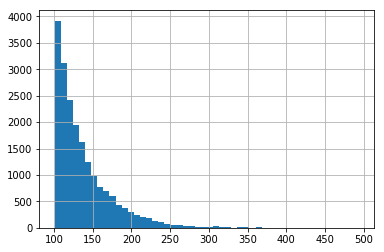

In [87]:
m_count[m_count > 100].hist(bins=50)

In [88]:
topk_m_code = pd.DataFrame({
    "m_code_rank{}".format(i + 1): merchant_rank[merchant_rank.m_rank == i + 1].set_index("card_id").m_code + 1
    for i in range(150)
}).fillna(0).astype(int)

In [91]:
topk_m_code.head().T.head()

,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0,C_ID_0001793786,C_ID_000183fdda
m_code_rank1,193598,273815,232546,160201,317949
m_code_rank2,95419,228205,149666,191279,18933
m_code_rank3,137383,13012,89631,25238,274399
m_code_rank4,27976,84668,194168,79412,148211
m_code_rank5,311970,221955,227216,59279,122220


In [92]:
merchant_rank.head()

,card_id,m_code,total_pa,m_rank
12917514,C_ID_fffffd5772,266929,534.0000000000,1.0000000000
12917504,C_ID_fffffd5772,111938,418.3800000000,2.0000000000
12917517,C_ID_fffffd5772,303349,389.0000000000,3.0000000000
12917503,C_ID_fffffd5772,89231,320.0000000000,4.0000000000
12917509,C_ID_fffffd5772,195863,281.7000000000,5.0000000000


In [93]:
topk_m_value = pd.DataFrame({
    "m_value_rank{}".format(i + 1): merchant_rank[merchant_rank.m_rank == i + 1].set_index("card_id").total_pa
    for i in range(150)
}).fillna(0)

# save data

In [110]:
monthly_payment_features.head().reset_index().rename(columns={"index": "card_id"})

,card_id,main_m_lag0,main_m_lag1,main_m_lag2,main_m_lag3,main_m_lag4,main_m_lag5,main_m_lag6,main_m_lag7,main_m_lag8,main_m_lag9,main_m_lag10,main_m_lag11,main_m_lag12,main_m_lag13,main_m_lag14,main_m_lag15
0,C_ID_00007093c1,0,137383,193598,137383,27976,311970,193598,95419,4566,170331,173571,311970,193598,173571,0,855
1,C_ID_0001238066,0,0,0,0,0,0,0,0,273815,273815,273815,273815,13012,273815,216501,200595
2,C_ID_0001506ef0,119177,1282,219420,0,89631,232546,232546,232546,232546,232546,232546,232546,232546,232546,224019,0
3,C_ID_0001793786,160201,220621,191279,160201,88866,59279,25238,79412,251770,314251,236548,148917,0,0,0,0
4,C_ID_000183fdda,0,0,0,0,0,0,0,317949,99420,131958,197125,122220,18933,148211,90518,78198


In [109]:
monthly_payment_pa.head().reset_index().rename(columns={"index": "card_id"}).fillna(0)

,card_id,main_m_lag0,main_m_lag1,main_m_lag2,main_m_lag3,main_m_lag4,main_m_lag5,main_m_lag6,main_m_lag7,main_m_lag8,main_m_lag9,main_m_lag10,main_m_lag11,main_m_lag12,main_m_lag13,main_m_lag14,main_m_lag15
0,C_ID_00007093c1,0.0000000000,521.8000000000,653.0000000000,718.4500000000,2204.0000000000,1400.0000000000,331.0000000000,2900.0000000000,220.0000000000,413.0000000000,527.0000000000,782.0000000000,430.0000000000,500.0000000000,0.0000000000,60.0000000000
1,C_ID_0001238066,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,127.1300000000,430.0100000000,661.5600000000,792.7100000000,1008.2200000000,771.8300000000,444.9400000000,250.0000000000
2,C_ID_0001506ef0,39.0000000000,79.0000000000,58.2000000000,0.0000000000,30.0000000000,16.3300000000,1017.0000000000,842.0000000000,750.0000000000,910.7400000000,881.1400000000,750.0000000000,1100.0000000000,1491.0000000000,9.9200000000,0.0000000000
3,C_ID_0001793786,1174.8300000000,1475.5800000000,2290.1800000000,2078.1700000000,1621.6100000000,3527.8000000000,5733.9000000000,1650.8000000000,3445.7600000000,1443.2500000000,2580.0000000000,1500.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,C_ID_000183fdda,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2158.2000000000,609.2000000000,541.2200000000,1764.9000000000,1960.0000000000,2337.0000000000,1374.9300000000,191.2000000000,425.4000000000


In [105]:
topk_m_code.head().reset_index().rename(columns={"index": "card_id"})

,card_id,m_code_rank1,m_code_rank2,m_code_rank3,m_code_rank4,m_code_rank5,m_code_rank6,m_code_rank7,m_code_rank8,m_code_rank9,...,m_code_rank141,m_code_rank142,m_code_rank143,m_code_rank144,m_code_rank145,m_code_rank146,m_code_rank147,m_code_rank148,m_code_rank149,m_code_rank150
0,C_ID_00007093c1,193598,95419,137383,27976,311970,173571,170331,115124,213290,...,0,0,0,0,0,0,0,0,0,0
1,C_ID_0001238066,273815,228205,13012,84668,221955,216501,234359,197526,39974,...,0,0,0,0,0,0,0,0,0,0
2,C_ID_0001506ef0,232546,149666,89631,194168,227216,193152,154121,70463,193068,...,0,0,0,0,0,0,0,0,0,0
3,C_ID_0001793786,160201,191279,25238,79412,59279,251770,80322,97691,314251,...,324568,247283,19492,314370,307627,221809,283388,54335,259109,330051
4,C_ID_000183fdda,317949,18933,274399,148211,122220,197125,136453,326558,151597,...,0,0,0,0,0,0,0,0,0,0


In [104]:
topk_m_value.head().reset_index().rename(columns={"index": "card_id"})

,card_id,m_value_rank1,m_value_rank2,m_value_rank3,m_value_rank4,m_value_rank5,m_value_rank6,m_value_rank7,m_value_rank8,m_value_rank9,...,m_value_rank141,m_value_rank142,m_value_rank143,m_value_rank144,m_value_rank145,m_value_rank146,m_value_rank147,m_value_rank148,m_value_rank149,m_value_rank150
0,C_ID_00007093c1,3898.3000000000,2900.0000000000,2598.3000000000,2204.0000000000,2182.0000000000,1152.0000000000,1043.0000000000,950.5000000000,800.9900000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,C_ID_0001238066,3044.0100000000,1210.5800000000,1008.2200000000,660.0000000000,452.0000000000,444.9400000000,395.9000000000,389.6000000000,300.0200000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,C_ID_0001506ef0,7758.2100000000,380.2100000000,271.9200000000,245.0000000000,140.0000000000,110.0000000000,104.9000000000,90.9000000000,84.0900000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,C_ID_0001793786,8912.1400000000,6894.8100000000,5733.9000000000,4168.7000000000,3527.8000000000,3445.7600000000,2913.6500000000,2910.0000000000,2833.2500000000,...,25.0000000000,24.4500000000,23.5000000000,23.4800000000,20.0000000000,14.9000000000,13.5000000000,6.0000000000,6.0000000000,2.0000000000
4,C_ID_000183fdda,2554.2000000000,2337.0000000000,2167.2300000000,2158.6100000000,1960.0000000000,1764.9000000000,1190.0000000000,1099.3200000000,994.2500000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [111]:
save_dataframe32_int(features_downcast("main_m_code16"),
                     monthly_payment_features.reset_index().rename(columns={"index": "card_id"}),
                     keep=["card_id"])

save_dataframe32(features_downcast("main_m_value16"),
                 monthly_payment_pa.reset_index().rename(columns={"index": "card_id"}).fillna(0),
                 keep=["card_id"])

save_dataframe32_int(features_downcast("topk_m_code150"),
                     topk_m_code.reset_index().rename(columns={"index": "card_id"}),
                     keep=["card_id"])

save_dataframe32(features_downcast("topk_m_value150"),
                 topk_m_value.reset_index().rename(columns={"index": "card_id"}),
                 keep=["card_id"])